<i><span style="color:#e74c3c;"><b>MAIN GOAL: </b>  I tried to fine-tune a DistilBERT model for solving a multi-class problem (multi output model). The first prediction is bias class (neutral or partisan), the second  prediction is message (policy, personal, support, information etc.). </span></i>


* I applied several <b>preprocessing</b> operations (cleaning,dropping stop words),
* Used <b>tf.data pipeline</b> for efficient training,
* I only used only 75 max length for sequence length (BERT models support up to 512 input lengths),


## My Another Projects
* [Complaint Analysis w/Ensemble Model (CatBoost, LR)](https://www.kaggle.com/code/banddaniel/complaint-analysis-w-ensemble-model-catboost-lr)
* [Gemma 2B Text Summarization w/Zero-Shot Prompting](https://www.kaggle.com/code/banddaniel/gemma-2b-text-summarization-w-zero-shot-prompting)
* [Crop Disease Classification w/Feature Fusion, DL Model](https://www.kaggle.com/code/banddaniel/crop-disease-classify-w-feature-fusion-dl-model)

In [1]:
# downgrade tensorflow for using huggingface distilbert model as embedding

from IPython.display import clear_output
!pip uninstall tensorflow -y
!pip install tensorflow==2.9.0
!pip install --user -U nltk spacy
clear_output()

In [2]:
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import *

from transformers import AutoTokenizer, TFDistilBertModel, DistilBertTokenizer, DistilBertConfig


SEED = 99
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

In [3]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
distil_bert = TFDistilBertModel.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# <span style="color:#e74c3c;"> Reading </span> Data

In [4]:
data = pd.read_csv('/kaggle/input/classification-of-pol-social/political_media_dfe.csv')
data.drop_duplicates(subset = ['text'], inplace = True)
data = data[['unit_id','bioid','bias','message','text']]

In [5]:
data.head()

,unit_id,bioid,bias,message,text
0,766192484,R000596,partisan,policy,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,M000355,partisan,attack,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,S001180,neutral,support,Please join me today in remembering our fallen...
3,766192487,C000880,neutral,policy,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,U000038,partisan,policy,.@amazon delivery #drones show need to update ...


# <span style="color:#e74c3c;"> Preprocessing </span>

In [6]:
# preprocessing functions

stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\w+\s*', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions 
full_data = data.copy()
full_data['preprocessed_text'] = data['text'].apply(text_preprocessing).apply(drop_stopwords).apply(delete_one_characters)


# label encoding
LE_for_bias = LabelEncoder()
full_data['encoded_bias'] = LE_for_bias.fit_transform(full_data['bias'].tolist())

LE_for_message = LabelEncoder()
full_data['encoded_message'] = LE_for_message.fit_transform(full_data['message'].tolist())

full_data.shape[0]

5000

In [7]:
# calculating max token numbers and dropping samples have 0,1 or 2 tokens
full_data['max']= full_data['preprocessed_text'].apply(lambda X: len(X.split()))


drop_idx = full_data[(full_data['max'] == 0) | (full_data['max'] == 1) | (full_data['max'] == 2)].index
full_data.drop(index = drop_idx, inplace = True)

full_data.shape[0]

4939

In [8]:
# after preprocessing functions
full_data.head()

,unit_id,bioid,bias,message,text,preprocessed_text,encoded_bias,encoded_message,max
0,766192484,R000596,partisan,policy,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,rt rep trey radel fl slams obamacare politics co,1,7,9
1,766192485,M000355,partisan,attack,VIDEO - #Obamacare: Full of Higher Costs and ...,video obamacare full higher costs broken promi...,1,0,8
2,766192486,S001180,neutral,support,Please join me today in remembering our fallen...,please join today remembering fallen heroes ho...,0,8,13
3,766192487,C000880,neutral,policy,RT @SenatorLeahy: 1st step toward Senate debat...,rt step toward senate debate leahy crapo vawa ...,0,7,14
4,766192488,U000038,partisan,policy,.@amazon delivery #drones show need to update ...,delivery drones show need update law promote i...,1,7,14


# <span style="color:#e74c3c;"> Dataset </span> Splitting

In [9]:
# train and test splitting

train_val_data, test_data = train_test_split(full_data, test_size = 0.12, random_state = SEED, stratify = full_data['encoded_message'])
train_data, val_data = train_test_split(train_val_data, test_size = 0.15, random_state = SEED, stratify = train_val_data['encoded_message'])


print('train samples :\t', train_data.shape[0])
print('val samples :\t', val_data.shape[0])
print('test samples :\t', test_data.shape[0])

train samples :	 3694
val samples :	 652
test samples :	 593


# <span style="color:#e74c3c;"> Tokenizing </span>

In [10]:
MAX_LEN = 75

X_train = tokenizer(text=train_data['preprocessed_text'].tolist(), add_special_tokens=True,
                    max_length= MAX_LEN, truncation=True, padding=True, return_tensors='tf',
                    return_token_type_ids=False, return_attention_mask=True, verbose=True)

X_valid = tokenizer(text=val_data['preprocessed_text'].tolist(), add_special_tokens=True,
                    max_length= MAX_LEN, truncation=True, padding=True, return_tensors='tf',
                    return_token_type_ids=False, return_attention_mask=True, verbose=True)

X_test = tokenizer(text=test_data['preprocessed_text'].tolist()[:40000], add_special_tokens=True,
                   max_length= MAX_LEN, truncation=True, padding=True, return_tensors='tf',
                   return_token_type_ids=False, return_attention_mask=True, verbose=True)

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [11]:
# a function for tf.data pipeline
def parsing(text, label_bias, label_message):
    input_ids = text['input_ids']
    attention_mask = text['attention_mask']
    
    return {'input_ids': input_ids, 'attention_mask' : attention_mask}, {'out_bias': label_bias, 'out_message': label_message}

In [12]:
# tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((X_train, train_data['encoded_bias'], train_data['encoded_message']))
train_dataset = (train_loader.map(parsing, num_parallel_calls = AUTO).shuffle(BATCH_SIZE*20).batch(BATCH_SIZE).prefetch(AUTO))

valid_loader = tf.data.Dataset.from_tensor_slices((X_valid, val_data['encoded_bias'], val_data['encoded_message']))
valid_dataset = (valid_loader.map(parsing, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((X_test, test_data['encoded_bias'], test_data['encoded_message']))
test_dataset = (test_loader.map(parsing, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

# <span style="color:#e74c3c;"> Fine-tuning TFDistilBert </span>  Model

In [13]:
input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")
embeddings = distil_bert(input_ids, attention_mask = input_mask)[0] 

X = GlobalMaxPool1D()(embeddings)
X = Dense(128, activation='gelu')(X)
X = Dropout(0.1)(X)
X = Dense(32,activation = 'gelu')(X)
out_bias = Dense(2, activation = 'softmax', name = 'out_bias')(X)
out_message = Dense(9,activation = 'softmax', name = 'out_message')(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=[out_bias, out_message])

# for distilbert tuning
model.layers[2].trainable = True

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=6e-06), loss = {"out_bias":  tf.keras.losses.SparseCategoricalCrossentropy(),"out_message": tf.keras.losses.SparseCategoricalCrossentropy()},
              metrics = {'out_bias': 'acc', 'out_message': 'acc'})
model.summary()

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience = 4, min_delta = 0.001),
                tf.keras.callbacks.ModelCheckpoint('/kaggle/working/model.best.weights.h5', save_best_only=True, save_weights_only=True)]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 75)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 75, 768),                                                    
                                 hidden_states=None                                           

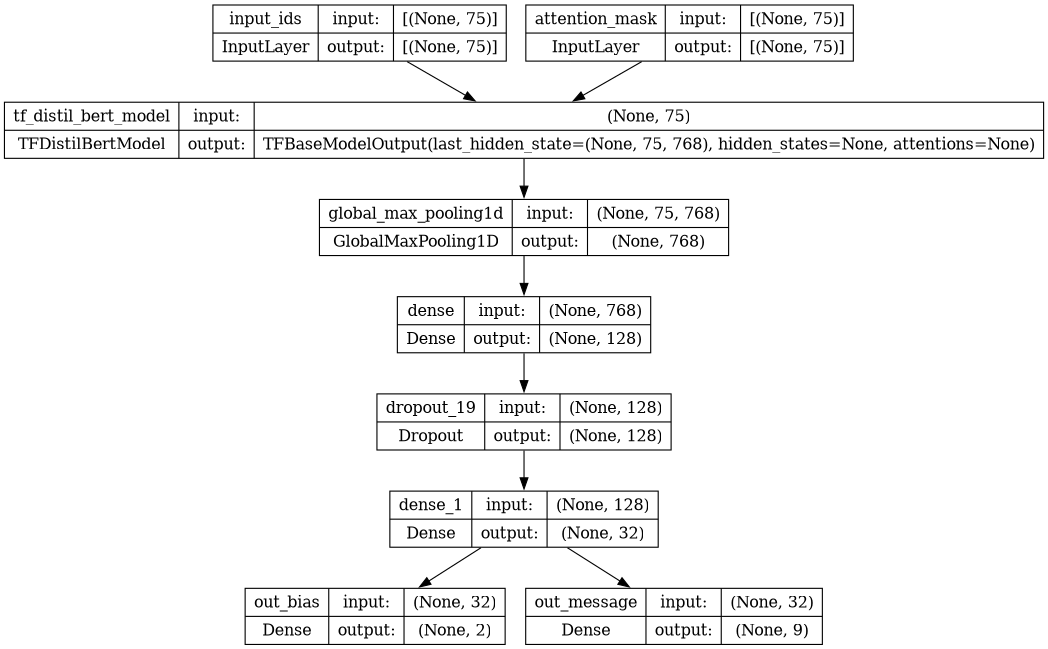

In [14]:
# plotting the model
tf.keras.utils.plot_model(model, show_shapes=True, dpi=80)

In [15]:
# training
hist = model.fit(train_dataset, validation_data = valid_dataset, epochs = 10, callbacks = my_callbacks)

Epoch 1/10
58/58 [==============================] - 473s 8s/step - loss: 2.5675 - out_bias_loss: 0.5698 - out_message_loss: 1.9977 - out_bias_acc: 0.7398 - out_message_acc: 0.2680 - val_loss: 2.4173 - val_out_bias_loss: 0.5648 - val_out_message_loss: 1.8525 - val_out_bias_acc: 0.7147 - val_out_message_acc: 0.2899
Epoch 2/10
58/58 [==============================] - 445s 8s/step - loss: 2.3317 - out_bias_loss: 0.5162 - out_message_loss: 1.8156 - out_bias_acc: 0.7439 - out_message_acc: 0.3257 - val_loss: 2.2565 - val_out_bias_loss: 0.4950 - val_out_message_loss: 1.7615 - val_out_bias_acc: 0.7408 - val_out_message_acc: 0.3911
Epoch 3/10
58/58 [==============================] - 451s 8s/step - loss: 2.2160 - out_bias_loss: 0.4705 - out_message_loss: 1.7455 - out_bias_acc: 0.7718 - out_message_acc: 0.3882 - val_loss: 2.1989 - val_out_bias_loss: 0.4768 - val_out_message_loss: 1.7221 - val_out_bias_acc: 0.7546 - val_out_message_acc: 0.4248
Epoch 4/10
58/58 [==============================] - 458

# <span style="color:#e74c3c;"> Test </span>  Predictions

In [16]:
# test predictions
pred = model.predict(test_dataset)

test_pred_bias = np.argmax(pred[0], axis = 1)
y_test_bias = test_data['encoded_bias'].values

test_pred_message = np.argmax(pred[1], axis = 1)
y_test_message = test_data['encoded_message'].values

10/10 [==============================] - 23s 2s/step


In [17]:
# a function for calculating and plotting predictions 
def plot_prediction_results(y_true, y_pred, label_encoder):
    
    mse = mean_squared_error(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    clf = classification_report(y_true, y_pred, target_names = list(label_encoder.classes_))
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels = list(label_encoder.classes_),  xticks_rotation="vertical", values_format = '2g', cmap = 'bone', colorbar = False)

# <span style="color:#e74c3c;"> (Bias) Test </span>  Results

Mean Squared Error :	0.20911
Weighted F1 Score :	0.781
Accuracy Score :	79.089 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

     neutral       0.83      0.90      0.86       436
    partisan       0.64      0.48      0.55       157

    accuracy                           0.79       593
   macro avg       0.73      0.69      0.71       593
weighted avg       0.78      0.79      0.78       593

----------------------------------------------------------------------

 Confusion Matrix: 



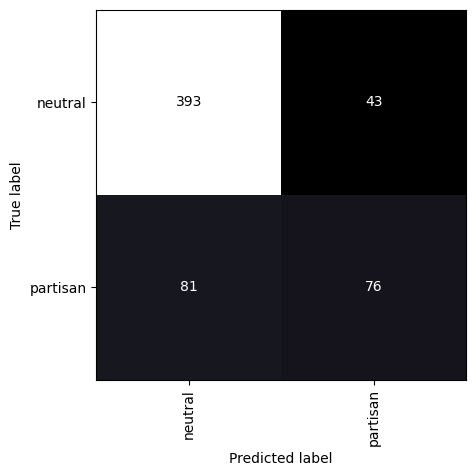

In [18]:
plot_prediction_results(y_test_bias, test_pred_bias, LE_for_bias)

# <span style="color:#e74c3c;"> (Message) Test </span>  Results

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean Squared Error :	7.93255
Weighted F1 Score :	0.377
Accuracy Score :	41.653 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

      attack       0.00      0.00      0.00        20
constituency       0.00      0.00      0.00        18
 information       0.25      0.32      0.28        77
       media       0.46      0.33      0.39        33
mobilization       0.00      0.00      0.00        15
       other       0.00      0.00      0.00        14
    personal       0.44      0.60      0.51       137
      policy       0.53      0.67      0.59       169
     support       0.24      0.15      0.18       110

    accuracy                           0.42       593
   macro avg       0.21      0.23      0.22       593
weighted avg       0.35      0.42      0.38       593

----------------------------------------------------------------------

 Confusion Matrix: 



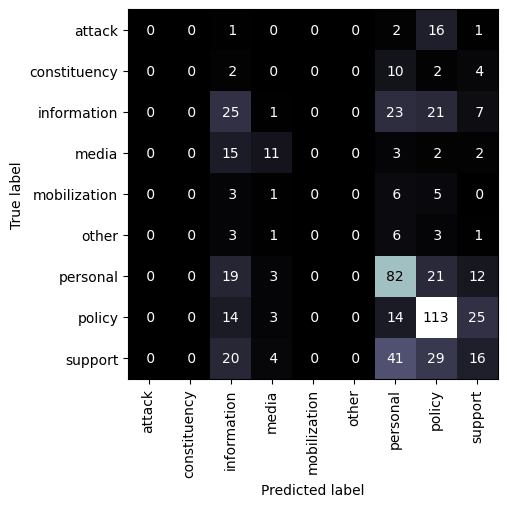

In [19]:
plot_prediction_results(y_test_message, test_pred_message, LE_for_message)